## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [175]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# importing wordcloud
from wordcloud import WordCloud

# prediction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [177]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(10000, random_state=1)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688"
50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744"
205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [178]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
        
    doc = nlp(text)
    
    # I changed the given code in order to remove the text that starts with @ and # before I removed punctuation
    
    spacy_words = []
    for token in doc:
        if not (token.is_stop or token.like_num or token.like_url or token.like_email or token.text.startswith(('@', '#'))):
            # Now removing punctuation and joining 
            no_punc = "".join([ch for ch in token.text if ch not in punc])
            # Removing flag for retweet "RT"
            if no_punc != 'RT':
                spacy_words.append(no_punc)
        
    return " ".join(spacy_words)

In [179]:
#double checking whats contained and being removed through punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [180]:
# now apply the function to the column "text" that contains the text of the tweets
# ----------
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(str(x))) # can use apply here 
print(congress_tweets['tokens'])

217331    Thank testifying today Mr Blake  QT gave impas...
258764    Twitter Town Hall healthcare begun answering q...
50091     Scipio Jones ‘ fight civil rights equality imp...
205601    better time ActOnClimate EarthDay  role play p...
85993     understand VA problems recruiting qualified ph...
                                ...                        
625838    Republicans spent weeks funds dried asking asi...
942262    forever Black Panther Chadwick Boseman  thank ...
215892    Bahamian brothers sisters dire need help  Visi...
216011    Heartbreaking  cruel policies vulnerable child...
251502    RepDarrenSoto Schweikert calling Congress add ...
Name: tokens, Length: 10000, dtype: object


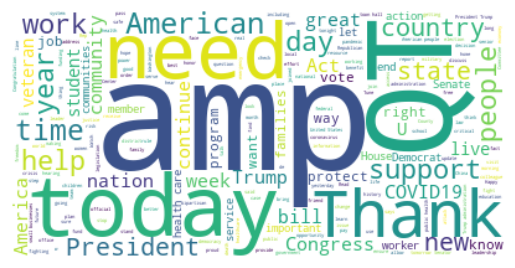

In [181]:
# Join all the tokens into a single string
all_tokens = ' '.join(congress_tweets['tokens'])

# Create the word cloud
wordcloud = WordCloud(background_color="white", random_state=2).generate(all_tokens)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Noticed other words that need to be cleaned / removed, and removing below

In [182]:
congress_tweets['tokens'] = congress_tweets['tokens'].apply(lambda text: ' '.join([word for word in text.split() if word not in ['QT', 'amp']]))

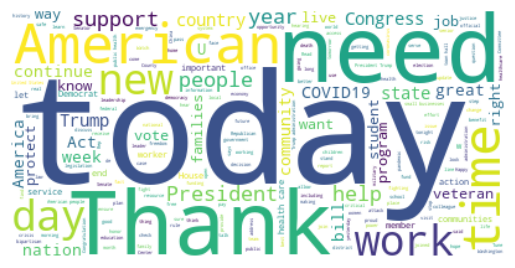

In [183]:
# Join all the tokens into a single string
all_tokens = ' '.join(congress_tweets['tokens'])

# Create the word cloud
wordcloud = WordCloud(background_color="white", random_state=2).generate(all_tokens)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1 -- Scattertext

Given the eventual classification tasks of predicting a legislator's party or which legislative house they belong to, I chose to use scattertext. Scattertext helps visualize differences between groups of documents which is useful in this case to explore the difference between the tweets of Democrats and Republicans.

In [184]:
import scattertext as st

In [185]:
# create measure of subjectivity
# ---------- 
corpus = st.CorpusFromPandas(congress_tweets[:5000],              # specify data
                             category_col = 'party', # specify the explanatory variable  
                             text_col = 'tokens',      # specify the text column
                             nlp = nlp).build()        # apply the nlp algorithim and build

In [186]:
# create html document
html = st.produce_scattertext_explorer(corpus,
                                       category='Democrat',
                                       category_name='Democrat',
                                       not_category_name='Republican',
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5)

In [187]:
# write html document to memory and open in browser
open("Congresstweetscatter.html", 'wb').write(html.encode('utf-8'))

2190554

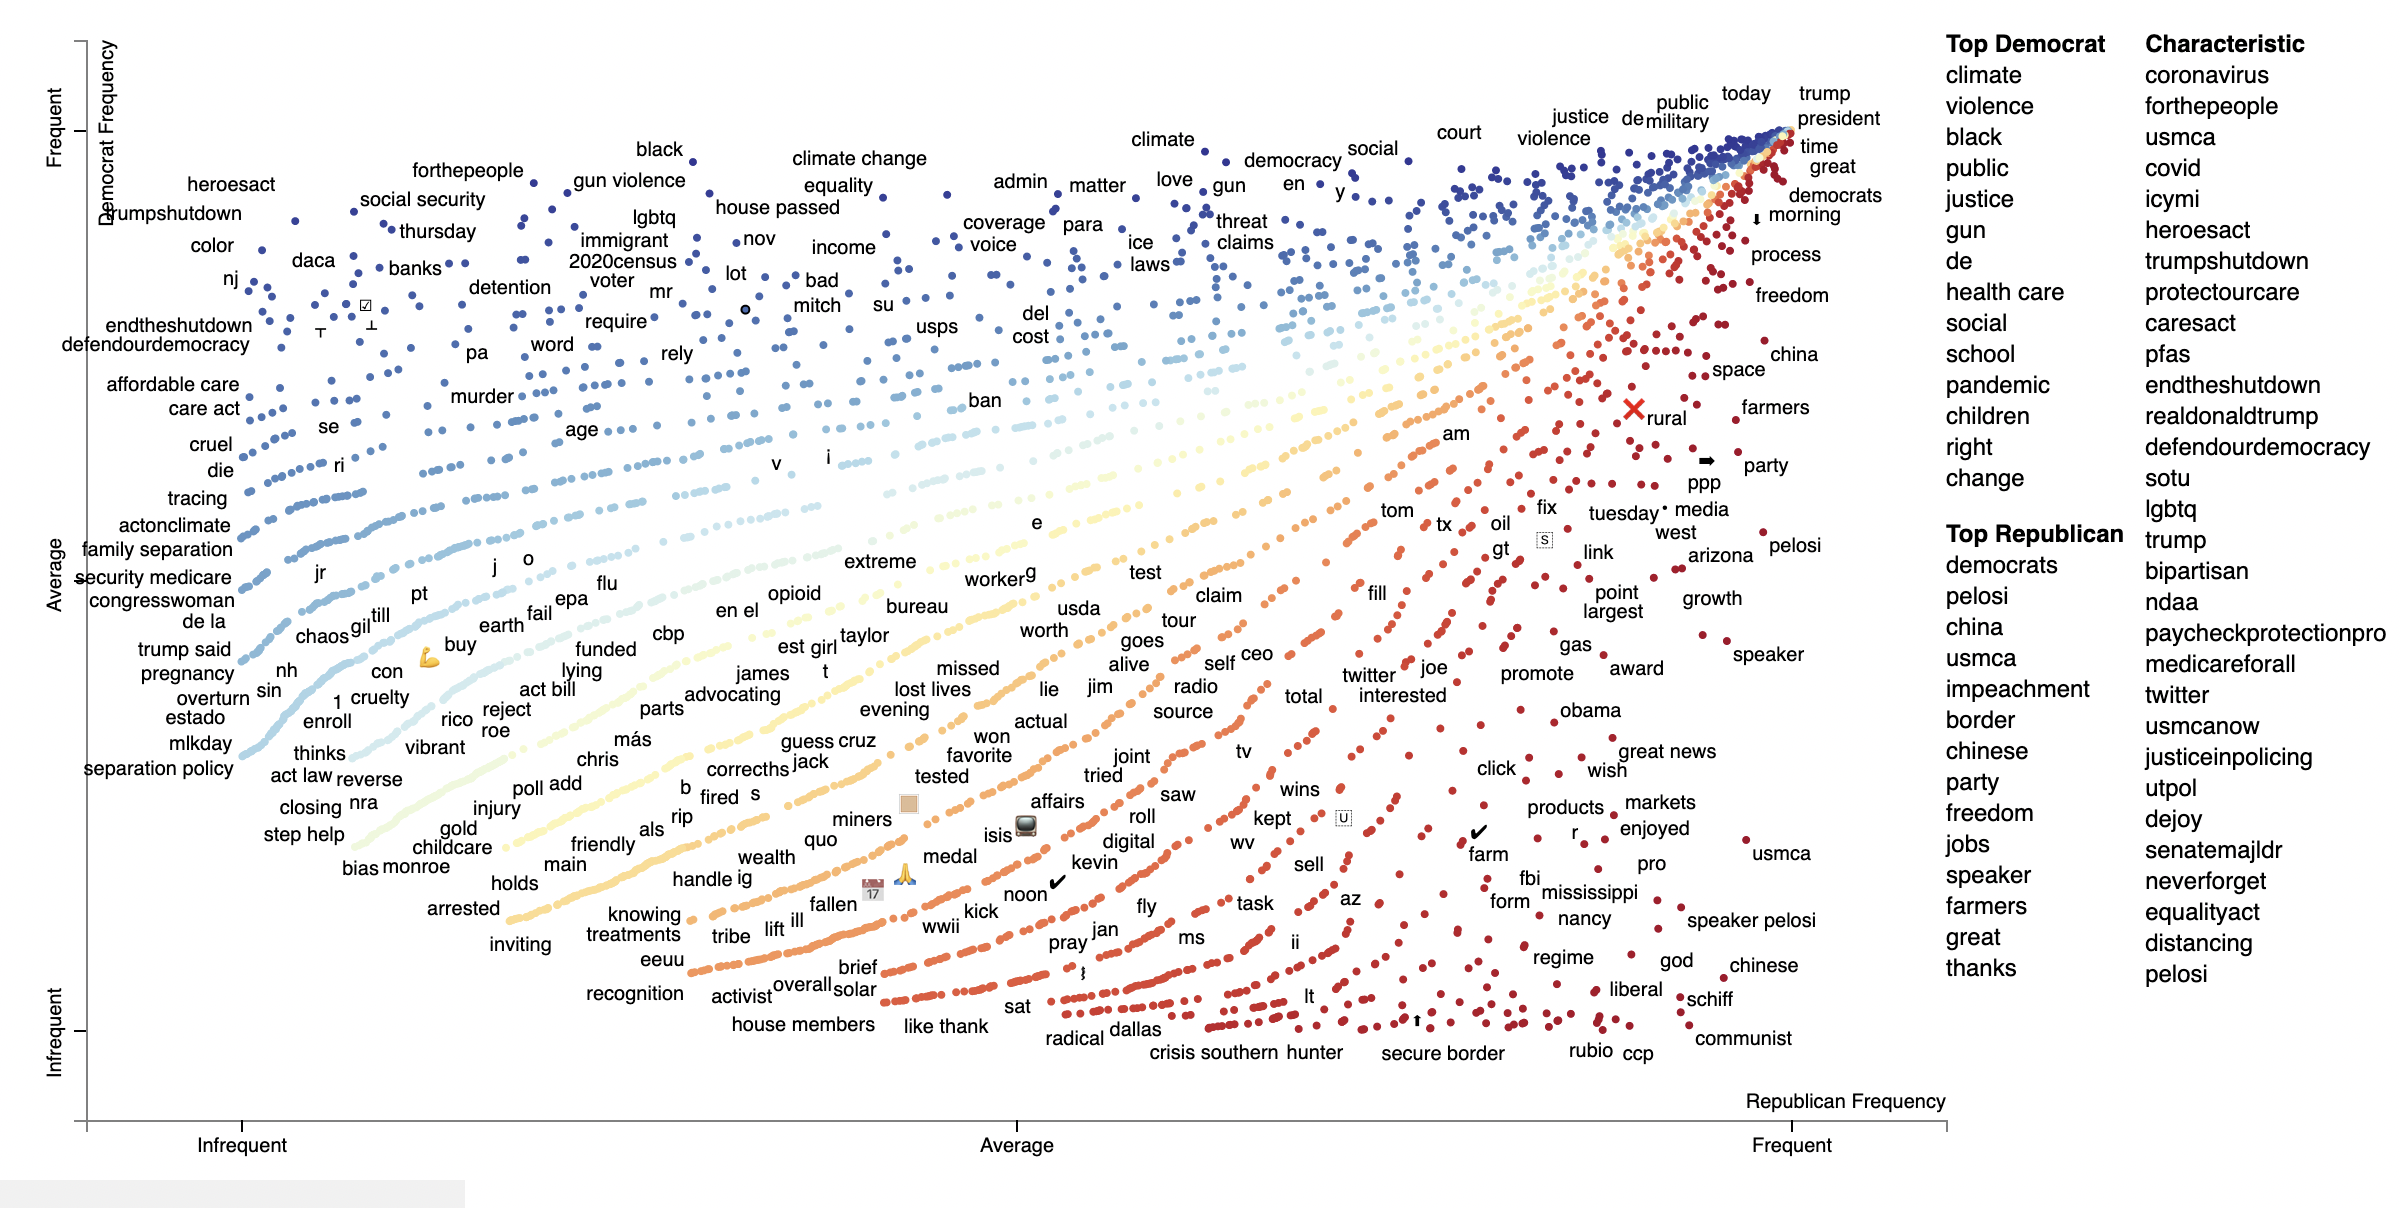

### EDA 2 -- Word count

I chose word count just to get a look at the distribution of words between each party Republican vs Democrat, and between legislative houses, Senate vs House. This can show me if for instance my corpus skews heavily to one party or another for instance if there are more words in one party's tweets.

Note I also already used wordcloud above as part of the visualization I did when pre-processing the texts.

In [188]:
# create new feature column with counts of # of words
# ----------

# count number of words
congress_tweets['word_count'] = congress_tweets['text'].apply(lambda x: len(str(x).split()))

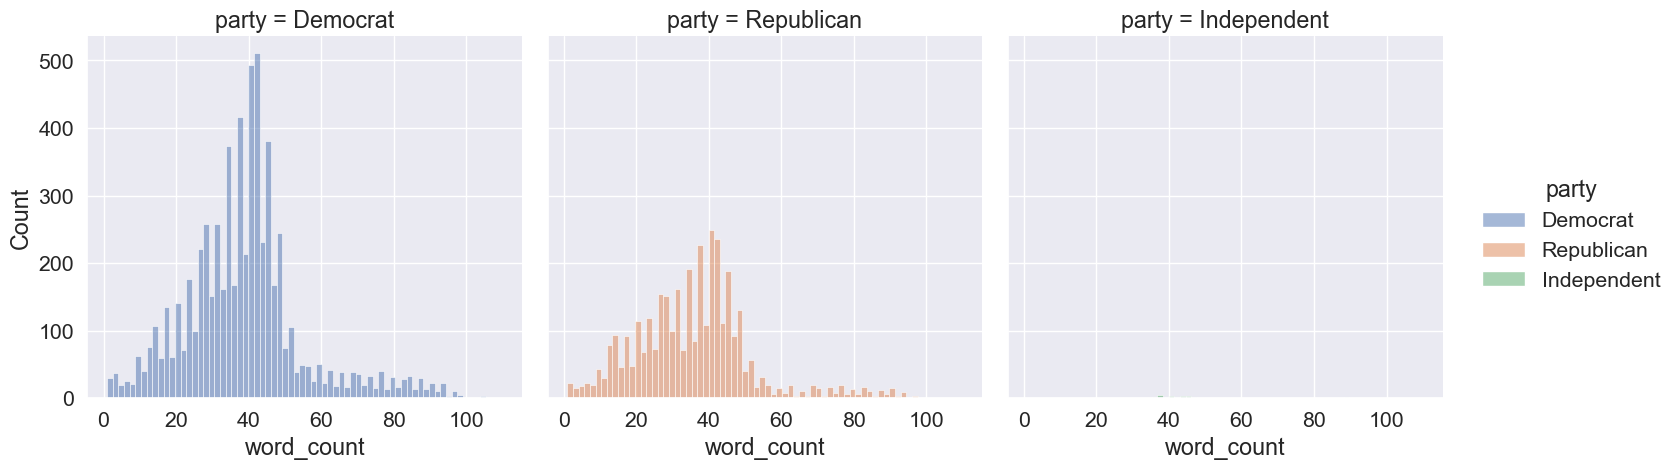

In [189]:
# histogram of word count by party 
sns.displot(congress_tweets,             # specify data
            x="word_count",   # x-axis feature
            hue = "party",  # color by loan product
            col = "party")  # color by loan product
plt.show()

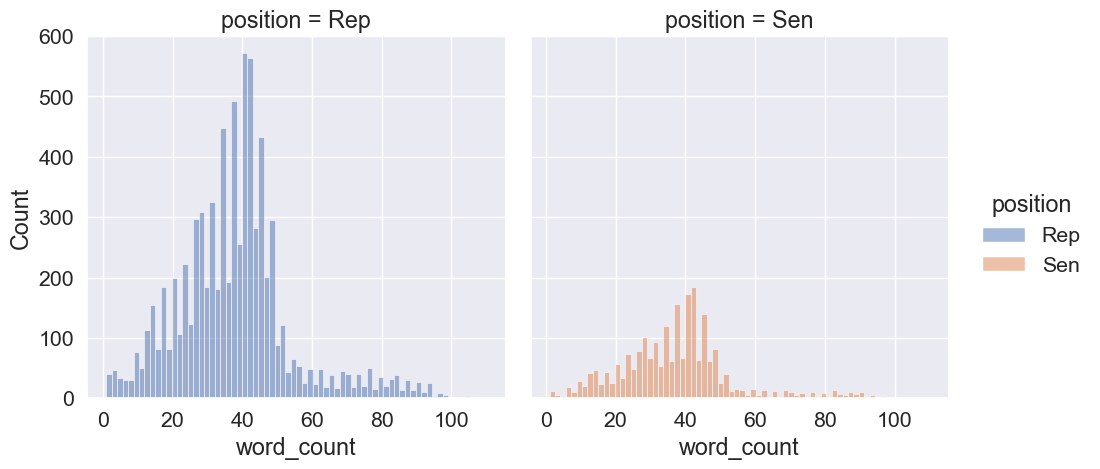

In [190]:
# histogram of word count by legislative house 
sns.displot(congress_tweets,             # specify data
            x="word_count",   # x-axis feature
            hue = "position",  # color by loan product
            col = "position")  # color by loan product
plt.show()

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [191]:
# create a feature colum of sentiment polarity

congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)

# create new column feature of subjectivity

congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# view
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,word_count,polarity,subjectivity
217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",Thank testifying today Mr Blake gave impassion...,30,0.000000,0.000000
258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688",Twitter Town Hall healthcare begun answering q...,20,0.136364,0.500000
50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744",Scipio Jones ‘ fight civil rights equality imp...,49,0.511111,0.833333
205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",better time ActOnClimate EarthDay role play pr...,27,0.450000,0.750000
85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958",understand VA problems recruiting qualified ph...,32,0.000000,0.000000


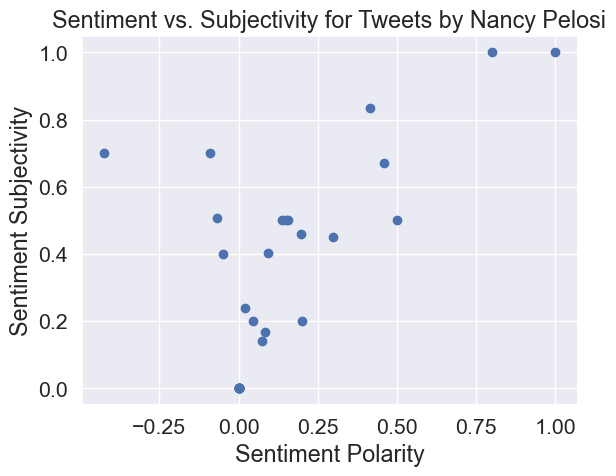

In [192]:
# Select rows where 'name_wikipedia' is 'Nancy Pelosi'
pelosi_tweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Nancy Pelosi']

# creating scatterplot of polarity vs subjectivity
plt.scatter(pelosi_tweets['polarity'], pelosi_tweets['subjectivity'])
plt.xlabel('Sentiment Polarity')
plt.ylabel('Sentiment Subjectivity')
plt.title('Sentiment vs. Subjectivity for Tweets by Nancy Pelosi')
plt.show()

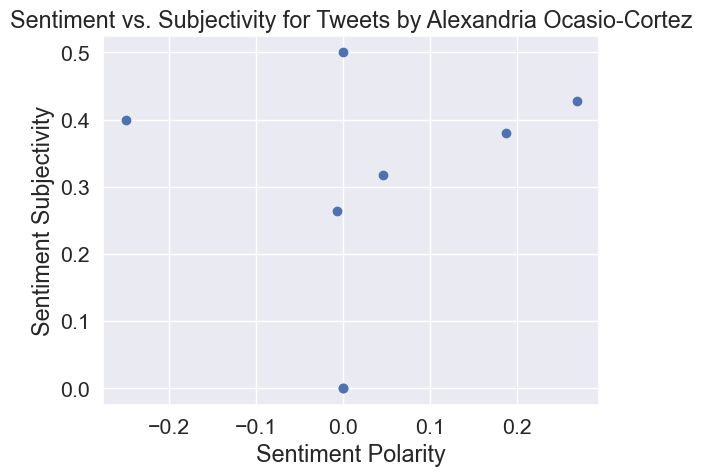

In [193]:
# Select rows where 'name_wikipedia' is 'Alexandria Ocasio-Cortez'
aoc_tweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Alexandria Ocasio-Cortez']

# creating scatterplot of polarity vs subjectivity
plt.scatter(aoc_tweets['polarity'], aoc_tweets['subjectivity'])
plt.xlabel('Sentiment Polarity')
plt.ylabel('Sentiment Subjectivity')
plt.title('Sentiment vs. Subjectivity for Tweets by Alexandria Ocasio-Cortez')
plt.show()

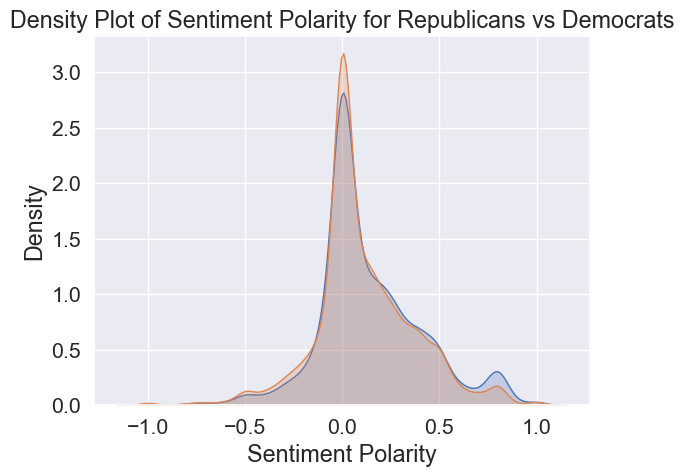

In [194]:
# Select rows where 'party' is 'Republican' and 'Democrat'
republican_tweets = congress_tweets[congress_tweets['party'] == 'Republican']
democrat_tweets = congress_tweets[congress_tweets['party'] == 'Democrat']

# Plot density plot for each party
sns.kdeplot(republican_tweets['polarity'], label='Republican', fill=True)
sns.kdeplot(democrat_tweets['polarity'], label='Democrat', fill=True)

# Set labels and title
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Polarity for Republicans vs Democrats')

# Show the plot
plt.show()

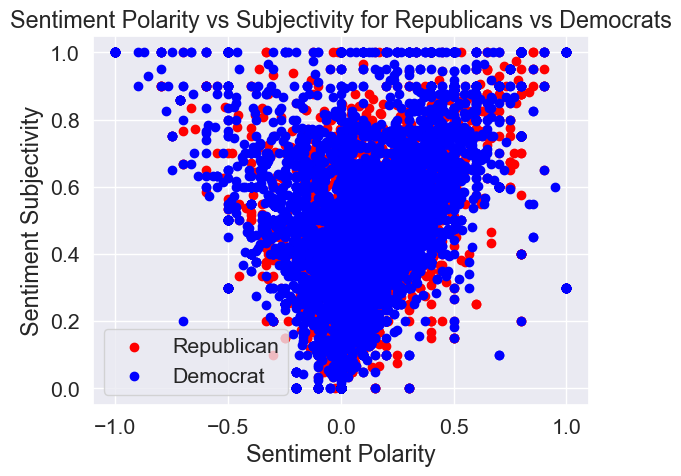

In [195]:
# Create a scatter plot for Republicans
plt.scatter(republican_tweets['polarity'], republican_tweets['subjectivity'], color='red', label='Republican')

# Create a scatter plot for Democrats
plt.scatter(democrat_tweets['polarity'], democrat_tweets['subjectivity'], color='blue', label='Democrat')

# Set labels and title
plt.xlabel('Sentiment Polarity')
plt.ylabel('Sentiment Subjectivity')
plt.title('Sentiment Polarity vs Subjectivity for Republicans vs Democrats')

# Add a legend
plt.legend()

# Show the plot
plt.show()

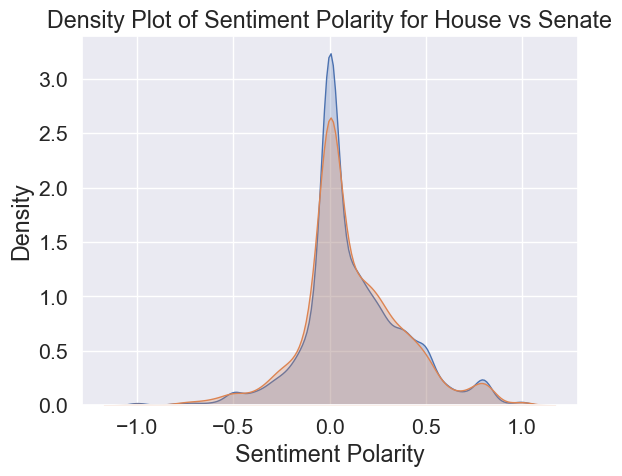

In [196]:
# Select rows where 'position' is 'Rep' and 'Sen'
house_tweets = congress_tweets[congress_tweets['position'] == 'Rep']
senate_tweets = congress_tweets[congress_tweets['position'] == 'Sen']

# Plot density plot for each position
sns.kdeplot(house_tweets['polarity'], label='Rep', fill=True)
sns.kdeplot(senate_tweets['polarity'], label='Sen', fill=True)

# Set labels and title
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Polarity for House vs Senate')

# Show the plot
plt.show()

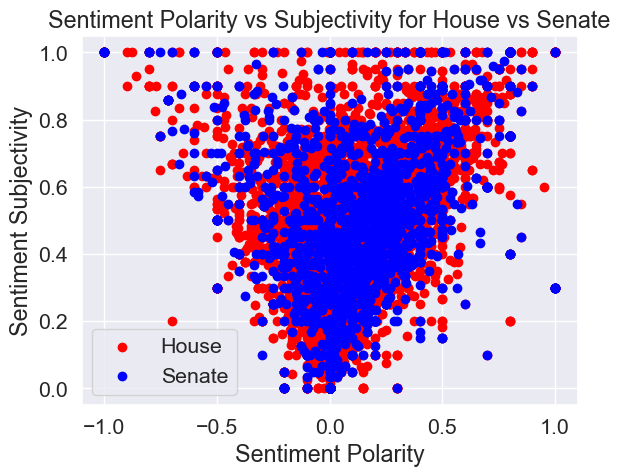

In [197]:
# Create a scatter plot for House tweets
plt.scatter(house_tweets['polarity'], house_tweets['subjectivity'], color='red', label='House')

# Create a scatter plot for Senate tweets
plt.scatter(senate_tweets['polarity'], senate_tweets['subjectivity'], color='blue', label='Senate')

# Set labels and title
plt.xlabel('Sentiment Polarity')
plt.ylabel('Sentiment Subjectivity')
plt.title('Sentiment Polarity vs Subjectivity for House vs Senate')

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [198]:
# since I am predicting Dem vs Republican I am taking out the independents from the dataset
# Filter the DataFrame
congress_tweets = congress_tweets[congress_tweets['party'].isin(['Republican', 'Democrat'])]

### Engineered Text Features

In [199]:
# Engineered Features
engineered_features = congress_tweets[['word_count', 'polarity', 'subjectivity']]

engineered_features.head()

,word_count,polarity,subjectivity
217331,30,0.000000,0.000000
258764,20,0.136364,0.500000
50091,49,0.511111,0.833333
205601,27,0.450000,0.750000
85993,32,0.000000,0.000000


### Bag-of-words or Tf-idf

In [200]:
# ran into an error so added this line to get rid of rows that potentially don't have text data and are throwing it 
if 'tokens' in congress_tweets and congress_tweets['tokens'].dtype == 'object':
    
    # Initialize TfidfVectorizer
    tf = TfidfVectorizer()

    # Fit and transform data
    tfidf_matrix = tf.fit_transform(congress_tweets['tokens'])

    # Create dense matrix
    dense_matrix = tfidf_matrix.todense()

    # Output
    print(dense_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [201]:
tfidf_df = pd.DataFrame(dense_matrix)

### Word Embedding

In [202]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [203]:
# alternatively if I didn't use the google news trained word2vec model
# from gensim.models import Word2Vec
# train model
# model = gensim.models.Word2Vec(congress_tweets['tokens'], vector_size=100, window=5, 
#                               min_count=5, sg=0, alpha=0.025, epochs = 5, batch_words=10000)

In [204]:
# Function to average word embeddings for a document

def document_vector(word2vec_model, doc):
    # Filter out words that are not in the model's vocabulary
    doc = [word for word in doc if word in word2vec_model.key_to_index]

    # If doc is empty, return a vector of zeros
    if not doc:
        return numpy.zeros(word2vec_model.vector_size)
    
    # Get Word2Vec vectors for all words in doc
    vectors = [word2vec_model[word] for word in doc]

    # Calculate and return the mean of the vectors
    return numpy.mean(vectors, axis=0)

# Apply function to each document to get document vectors
document_vectors = congress_tweets['tokens'].apply(lambda doc: document_vector(model, doc))

# Create new DataFrame
word2vec_df = pd.DataFrame(document_vectors.tolist(), columns=[f'word2vec_dim_{i}' for i in range(300)])

# If you want to keep the original index from congress_tweets
word2vec_df.index = congress_tweets.index

word2vec_df.head()

,word2vec_dim_0,word2vec_dim_1,word2vec_dim_2,word2vec_dim_3,word2vec_dim_4,word2vec_dim_5,word2vec_dim_6,word2vec_dim_7,word2vec_dim_8,word2vec_dim_9,...,word2vec_dim_290,word2vec_dim_291,word2vec_dim_292,word2vec_dim_293,word2vec_dim_294,word2vec_dim_295,word2vec_dim_296,word2vec_dim_297,word2vec_dim_298,word2vec_dim_299
217331,-0.148126,0.103090,0.021851,0.153745,-0.031971,0.022672,-0.091257,-0.036009,-0.039398,0.002207,...,0.078032,-0.058849,-0.108250,0.098080,-0.020165,-0.141117,-0.089831,0.003376,-0.108605,0.165998
258764,-0.179214,0.099820,-0.019230,0.126104,-0.052388,0.032682,-0.085127,-0.075044,-0.048560,0.016003,...,0.068523,0.005449,-0.081486,0.074231,-0.034366,-0.166369,-0.113378,-0.022269,-0.125987,0.158507
50091,-0.169806,0.095964,0.017917,0.141137,-0.043522,0.003541,-0.077585,-0.067716,-0.040121,0.012511,...,0.050237,0.021462,-0.100173,0.090711,-0.048577,-0.166917,-0.122491,-0.011911,-0.101062,0.152974
205601,-0.187284,0.126528,-0.040309,0.141738,-0.079132,0.025056,-0.091760,-0.043996,-0.037972,0.016891,...,0.048768,-0.021619,-0.089779,0.079881,-0.005848,-0.143843,-0.084950,-0.023891,-0.090029,0.139139
85993,-0.167300,0.106015,0.009508,0.138727,-0.063550,0.025976,-0.083435,-0.055402,-0.055395,0.020790,...,0.078122,-0.014806,-0.105511,0.081373,-0.032281,-0.171067,-0.108482,-0.020546,-0.111881,0.159048


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

#### Three models (engineered features, tfidf, word embedding) for party

In [207]:
# create a list of dataframes from the objects created above
dataframes = [engineered_features,
              tfidf_df,
              word2vec_df]

# create a list of labeles based on the objects created above
featurization_technique = ['Engineered Text Features',
                           'Tf-idf Features',
                           'Word Embedding Features']

# model initalization and fit
# --------

from sklearn.preprocessing import LabelBinarizer

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data
y = congress_tweets['party_binary'] = lb_style.fit_transform(congress_tweets['party'])

In [208]:
print(lb_style.classes_)

['Democrat' 'Republican']


In [209]:
print(engineered_features.shape)
print(tfidf_df.shape)
print(word2vec_df.shape)
print(y.shape)

(9967, 3)
(9967, 20494)
(9967, 300)
(9967, 1)


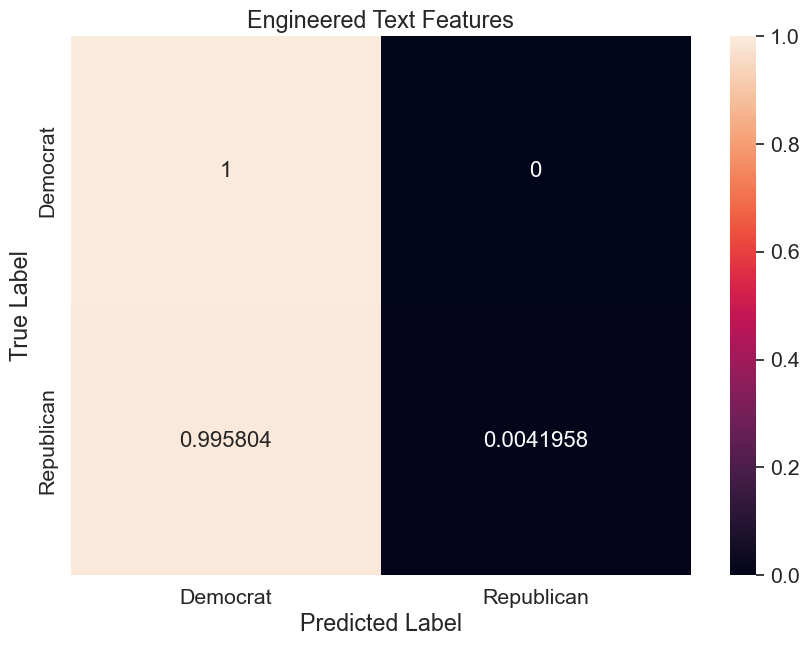

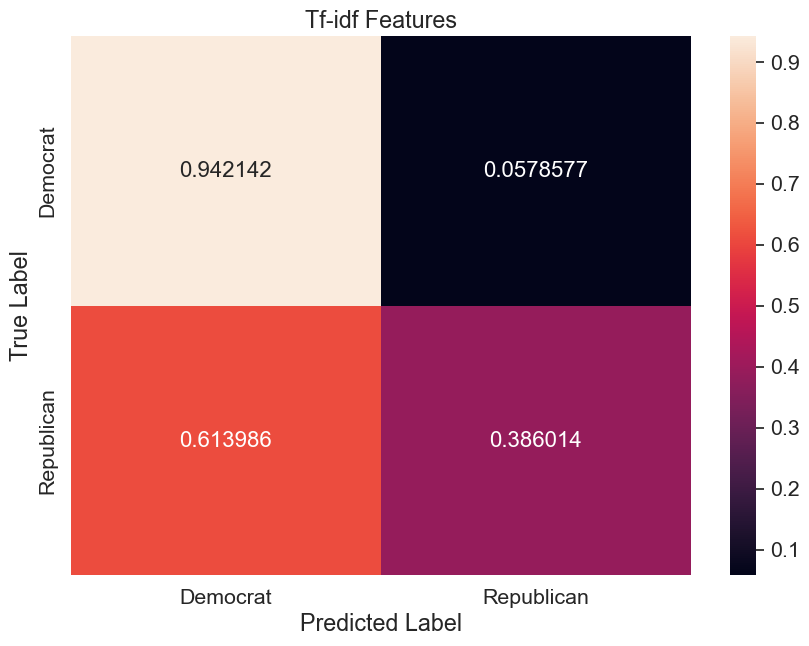

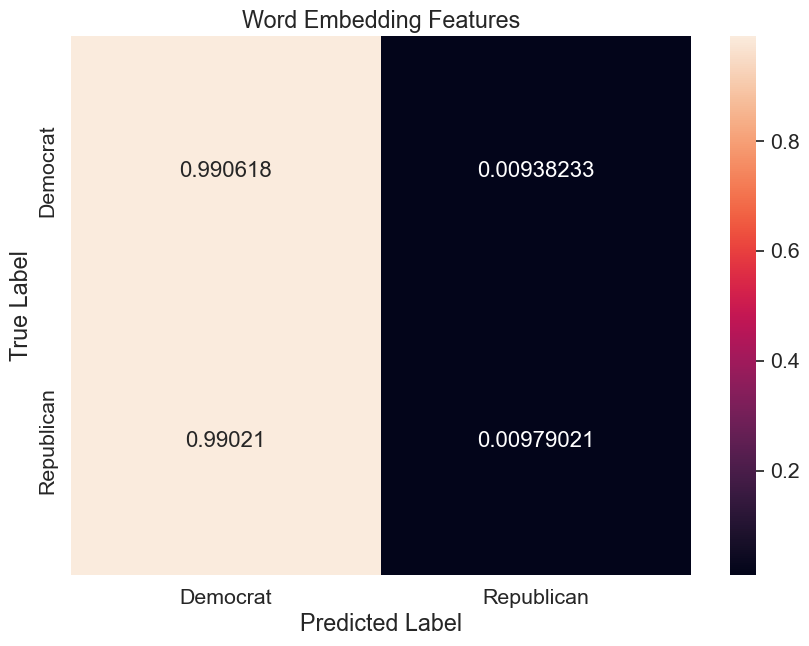

In [210]:
  
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# --------
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    # changing column names to strings because some are integer
    dataframe.columns = dataframe.columns.astype(str) 


    # split data
    # ----------
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=0.20,    # specify test split of 20%
                                                        random_state = 3) # set seed for reproducibility
    # apply Logit model 
    # ----------
    # initalize Logit model 
    logit_reg = LogisticRegression()

    # fit the model to our data
    logit_model = logit_reg.fit(X_train,         # specify feature data
                                y_train.ravel()) # specify label data --- don't forget to ravel the label dataset

    # predict on test set
    y_pred = logit_model.predict(X_test)
    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "true") # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,          # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Democrat", 
                                  1: "Republican"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Democrat", "Republican"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

#### Three models (engineered features, tfidf, word embedding) for legislative body

In [211]:
# model initalization and fit
# --------

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data
y = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets['position'])

In [212]:
print(lb_style.classes_)

['Rep' 'Sen']


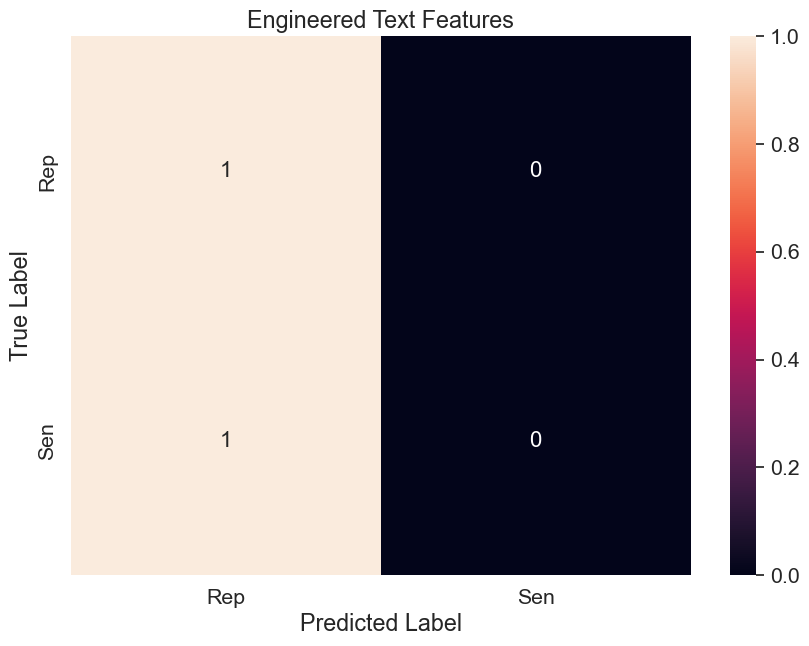

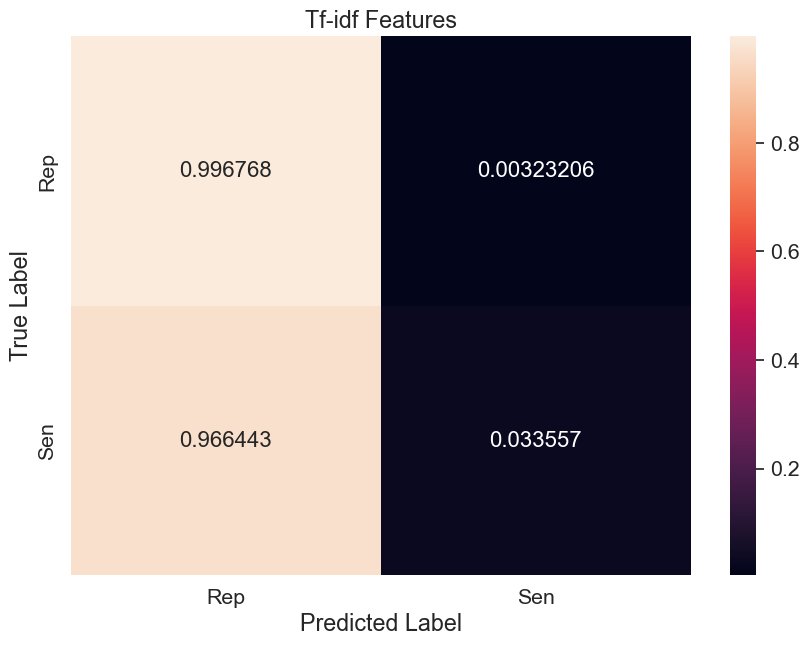

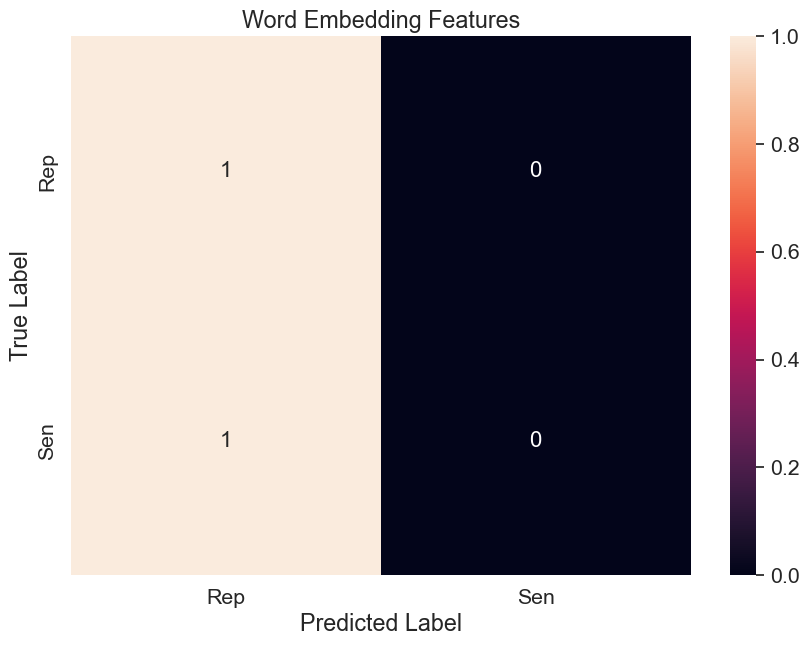

In [213]:
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# --------
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    # changing column names to strings because some are integer
    dataframe.columns = dataframe.columns.astype(str) 


    # split data
    # ----------
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=0.20,    # specify test split of 20%
                                                        random_state = 4) # set seed for reproducibility
    # apply Logit model 
    # ----------
    # initalize Logit model 
    logit_reg = LogisticRegression()

    # fit the model to our data
    logit_model = logit_reg.fit(X_train,         # specify feature data
                                y_train.ravel()) # specify label data --- don't forget to ravel the label dataset

    # predict on test set
    y_pred = logit_model.predict(X_test)
    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "true") # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,          # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Rep", 
                                  1: "Sen"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Rep", "Sen"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Two Combined Models

The best model from above three choices for text features was the tfidf. Now to combine with the non-text features and run again for predicting party and position

In [214]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'word_count', 'polarity',
       'subjectivity', 'party_binary', 'position_binary'],
      dtype='object')

In [235]:
# Getting non-text features
# --------
# select non-text features
# did not include the date columns such as joined congress date, date time etc
# or identifiers like name_wikipedia, screen_name
non_text_features = congress_tweets[[
    'position',  
    'gender',
    'state',
    'party',
    'trump_2016_state_share',
    'clinton_2016_state_share',
    'obama_2012_state_share',
    'romney_2012_state_share'
]]

# get dummies of non-text features
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)

# join the non text features to the tfidf dataframe
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)

#### Logit model predicting party with non-text features and tfidf features

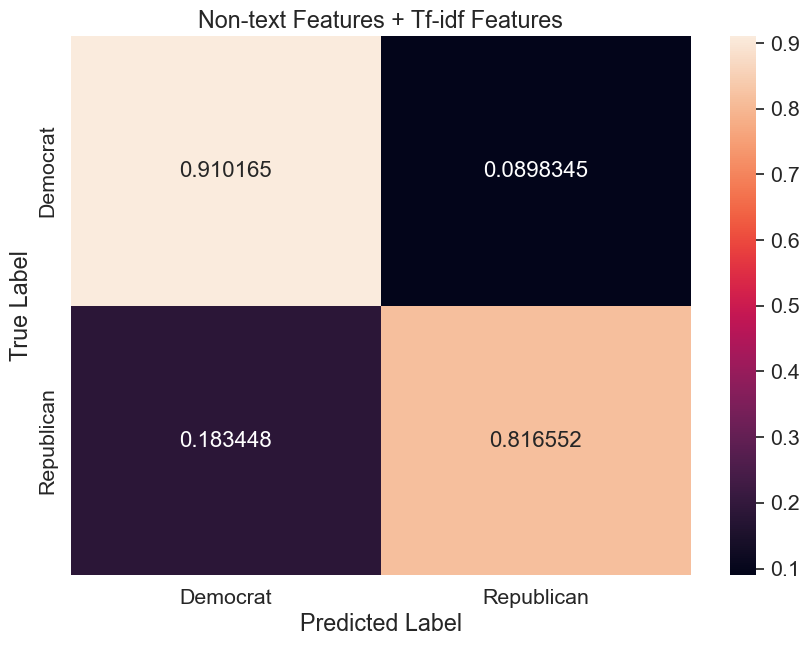

In [241]:
# drop target party
non_text_plus_tfidf_party = non_text_plus_tfidf.drop(columns=['party_Democrat', 'party_Republican'])

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data
y = congress_tweets['party_binary'] = lb_style.fit_transform(congress_tweets["party"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(non_text_plus_tfidf_party, y, train_size = .80, test_size=0.20, random_state = 5)

# Initialize and fit Logit model 
logit_reg = LogisticRegression(max_iter=1000)
logit_model = logit_reg.fit(X_train, y_train.ravel())

# Predict on test set
y_pred = logit_model.predict(X_test)

# Create a confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

# Create a pandas dataframe from the confusion matrix for visualization 
df_cm = pd.DataFrame(cf_matrix, range(2), range(2))

# Set confusion matrix indices for clarity of visualization
df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]

# Figure specifications 
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

# Figure labels
plt.title("Non-text Features + Tf-idf Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [243]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Accuracy:  0.8761283851554664
Precision:  0.8385269121813032
Recall:  0.8165517241379311
F1 Score:  0.8273934311670161


#### Logit model predicting position with non-text features and tfidf features

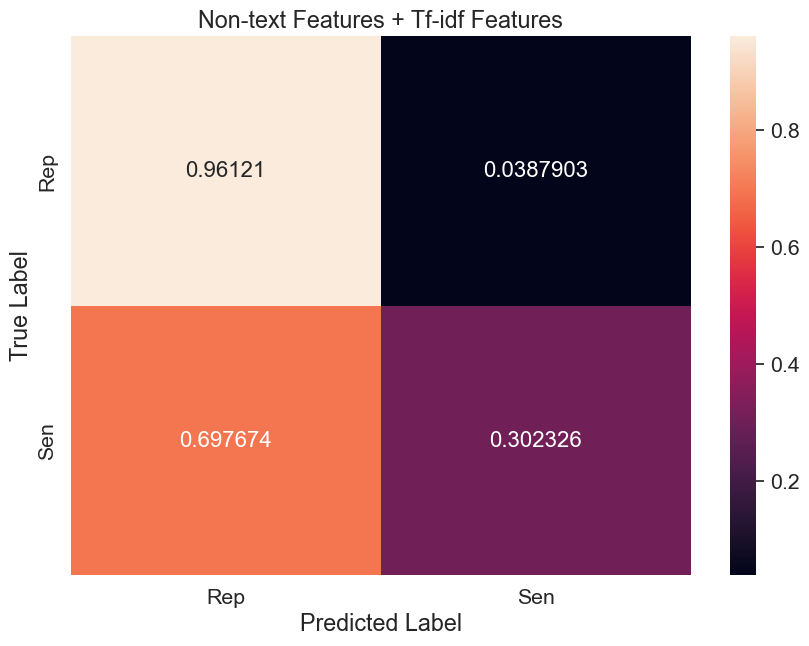

In [244]:
# drop target position
non_text_plus_tfidf_position = non_text_plus_tfidf.drop(columns=['position_Rep', 'position_Sen'])

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data
y = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(non_text_plus_tfidf_position, y, train_size = .80, test_size=0.20, random_state = 6)

# Initialize and fit Logit model 
logit_reg = LogisticRegression(max_iter=1000)
logit_model = logit_reg.fit(X_train, y_train.ravel())

# Predict on test set
y_pred = logit_model.predict(X_test)

# Create a confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

# Create a pandas dataframe from the confusion matrix for visualization 
df_cm = pd.DataFrame(cf_matrix, range(2), range(2))

# Set confusion matrix indices for clarity of visualization
df_cm = df_cm.rename(index=str, columns={0: "Rep", 1: "Sen"})
df_cm.index = ["Rep", "Sen"]

# Figure specifications 
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

# Figure labels
plt.title("Non-text Features + Tf-idf Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [245]:
# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Accuracy:  0.804914744232698
Precision:  0.7079207920792079
Recall:  0.3023255813953488
F1 Score:  0.42370370370370375


## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Standard preprocessing techniques include tokenizing, lowercasing, removing stopwords, stemming, and lemmatization. A particular corpus may use language in different ways, with different words and ways of writing that may need customization. For instance, here the tweet posts of political people will have different words than say a corpus of elementary school kid books. Also tweets will be short texts, with lots more abbreviations and unique slang and grammar than other texts. Tweets often contain urls, emojis, hashtags and mentions, which employ symbols differently than other texts. Therefore standard techniques need to be adjusted to the specific nature of the corpus. In this lab for instance, we needed something custom to remove urls or common abbreviations like RT.

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

In the sentiment analysis, we did not find much differences between Democrats and Republicans or between Senators and Republicans. Looking at the density plot of sentiment polarity, or the plots of sentiment vs subjectivity, we found that the results for these two categories tracked each other.

However the scattertext did show interesting differences in popular words for Dems vs Rep, like Democrats talking about gun violence or healthcare and Republicans talking about China or freedom.

How positive or negative they were wasn't the difference but definitely it tracks with our experience that the issues each party champsions are different.

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

Unsupervised and exploratory approachs can yield insights that may not have been surfaced without machine learning. However, one can then use supervised learning to confirm these insights. The supervised learning can confirm if the feature selections are useful. They can measure the performance of the model with accuracy, precision, recall metrics. The paper we read on Computational Grounded Theory provides a nice framework for how unsupervised and supervised approaches can be combined, with first pattern detection using unsupervised methods, pattern refinement using guided deep reading and finally pattern confirmation using natural language processing and the supervised algorithms.

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

The text plus non-text features performed the best. Surprisingly the tfidf performed better than the word embeddings. The tfidf plus nontext features performed even better. Since our word embeddings came from a model trained on news corpus, it may not perform well on tweets, especially also since we filtered out words that weren't in our congress_tweets corpus, if the tweets don't use the same words as the news, then its an even smaller sample. Since word embeddings depend on context, it may also struggle with the small sample size we have here, since there aren't as many words / context.

Adding nontext made the performance even better. More features may improve the performance, as well as adding features that are different from each other. Here, the nontext features were especially powerful, such as the voting share of different Republican and Democratic contestants, and the state they live in, all can imaginably be very connected to whether they are Republicans or Democrats.